In [1]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
##from tensorflow.keras.utils import multi_gpu_model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1712244228352170526
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3665166336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17266352512513268320
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


# Data Preprocessing

In [21]:
def generate_training_data(file):
    data=pd.read_csv(file)
    file_names=list(data['file_name'])
    labels=data['label'].values.reshape(-1,1)
    
    ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
    labels = ohe.fit_transform(labels)
    
    dataset_tumor=[]

    for file_index in range(len(file_names)):
        file=cv2.imread(data_path+"/image/"+file_names[file_index])
        file_resize=cv2.resize(file,(128,128))/255.
        dataset_tumor.append(file_resize)
        
    tumor_data = np.array(dataset_tumor)
    
    return tumor_data, labels

In [24]:
tumor_data, labels = generate_training_data("dataset/label.csv")
x_train,x_test,y_train,y_test=train_test_split(tumor_data,labels,test_size=0.2,random_state=25) 

# Training and Validation

In [12]:
x_train.shape

(2400, 128, 128, 3)

In [13]:
y_train.shape

(2400, 4)

In [14]:

initial_layer=keras.Input(shape=(128,128,3),name="image")

x1=layers.Conv2D(64,(22,22),strides=2)(initial_layer)
x1=layers.MaxPooling2D((4,4))(x1)
x1=layers.BatchNormalization()(x1)

x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
x2=layers.MaxPooling2D((2,2))(x2)
x2=layers.BatchNormalization()(x2)

x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
x3=layers.MaxPooling2D((2,2))(x3)
x3=layers.BatchNormalization()(x3)

x4=layers.Flatten()(x3)
x4=layers.Activation("relu")(x4)

x5=layers.Dense(1024,"relu")(x4)

x6=layers.Dense(256,"relu")(x5)

xfinal=layers.Dense(4)(x6)
pred=layers.Activation("softmax")(xfinal)

model=keras.Model(inputs=initial_layer,outputs=pred)

model.compile(loss="categorical_crossentropy",optimizer="sgd",  metrics=['mae', 'categorical_accuracy'])
model.fit(x_train,y_train,epochs=20,batch_size=32,shuffle=False)


Epoch 1/20
75/75 [==============================] - 4s 14ms/step - loss: 0.9176 - mae: 0.2681 - categorical_accuracy: 0.6404
Epoch 2/20
75/75 [==============================] - 1s 14ms/step - loss: 0.5294 - mae: 0.1715 - categorical_accuracy: 0.8283
Epoch 3/20
75/75 [==============================] - 1s 14ms/step - loss: 0.2847 - mae: 0.1011 - categorical_accuracy: 0.9321
Epoch 4/20
75/75 [==============================] - 1s 14ms/step - loss: 0.1215 - mae: 0.0486 - categorical_accuracy: 0.9833
Epoch 5/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0480 - mae: 0.0212 - categorical_accuracy: 0.9971
Epoch 6/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0240 - mae: 0.0109 - categorical_accuracy: 0.9992
Epoch 7/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0160 - mae: 0.0072 - categorical_accuracy: 0.9992
Epoch 8/20
75/75 [==============================] - 1s 14ms/step - loss: 0.0103 - mae: 0.0049 - categorical_accuracy: 0.9992


Usually here we assess the quality of the model based on the loss performance, if it is still unsatisfactory, we repeat with different hyperparameters until we arrive at an acceptable performance. After that, we can test our model on the leftover testing data we split earlier. This showcases our model's  ability to predict on unknown data.

# Testing

In [15]:
result=model.predict(x_test)
print(result)

[[9.9871552e-01 9.9569128e-04 2.3304154e-04 5.5783901e-05]
 [2.0418936e-04 2.5167369e-04 4.6770868e-04 9.9907637e-01]
 [1.4608307e-01 1.7337492e-01 6.7232591e-01 8.2160737e-03]
 ...
 [3.9260775e-01 6.0296851e-01 1.3339953e-03 3.0897609e-03]
 [9.8812872e-01 1.0380416e-02 1.1619834e-03 3.2893734e-04]
 [4.0293733e-05 3.1740885e-05 9.9990129e-01 2.6747250e-05]]


In [16]:
result.shape

(600, 4)

In [17]:
result_eval = model.evaluate(x_test,y_test)
result_eval

19/19 [==============================] - 0s 8ms/step - loss: 0.3130 - mae: 0.0501 - categorical_accuracy: 0.9200


[0.3130335509777069, 0.0500527061522007, 0.9200000166893005]

Here after the softmax level, we need to obtain the single class that each input data corresponds to (according to the model), so we utilize argmax to determine the predicted class, which we will then compare to the original class.

C:\Users\BAGUSR~1\AppData\Local\Temp/ipykernel_2356/2816774879.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,y_test_class[:100],'r',label='real',color='orange')
C:\Users\BAGUSR~1\AppData\Local\Temp/ipykernel_2356/2816774879.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,result_class[:100],'b',label='pred',color='blue')


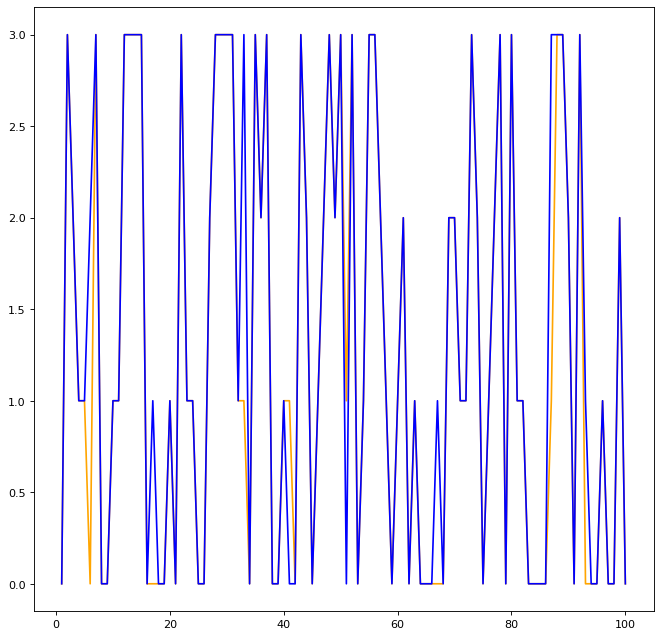

In [18]:
result_class = np.argmax(result, axis=1)
y_test_class = np.argmax(y_test, axis=1)
epochs=range(1,101)


#Continuous figure
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(epochs,y_test_class[:100],'r',label='real',color='orange')
plt.plot(epochs,result_class[:100],'b',label='pred',color='blue')

"""
#Discrete figure
fig = plt.figure(figsize=(10, 10), dpi=100)
ax1 = fig.add_subplot(111)
ax1.scatter(epochs,y_test_class[:100], s=10, c='b', marker="s", label='fig 1')
ax1.scatter(epochs,result_class[:100], s=10, c='r', marker="o", label='fig 2')
plt.legend(loc='upper left');
"""
plt.show()

In [19]:
acc = sklearn.metrics.accuracy_score(result_class, 
                                     y_test_class)
acc

0.92